<a href="https://colab.research.google.com/github/safaiat/CT_EXP/blob/main/L2_norm(x)%2B_Torch_MLE_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Weight = 0.01

Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-6-6a7fec3d2e7c>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.1706442832946777
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 10326787.000000
Iteration 100: Loss = 58823.656250
Iteration 150: Loss = 734.501709
Iteration 200: Loss = 515.853821
Iteration 250: Loss = 508.985535
Iteration 300: Loss = 505.902039
Iteration 350: Loss = 503.889801
Iteration 400: Loss = 502.424194
Iteration 450: Loss = 501.281067
Iteration 500: Loss = 500.347626
Iteration 550: Loss = 499.560822
Iteration 600: Loss = 498.882690
Iteration 650: Loss = 498.288452
Iteration 700: Loss = 497.761139
Iteration 750: Loss = 497.288910
Iteration 800: Loss = 496.862579
Iteration 850: Loss = 496.475281
Iteration 900: Loss = 496.121124
Iteration 950: Loss = 495.795898
Reconstruction completed.
Reconstructed image saved.


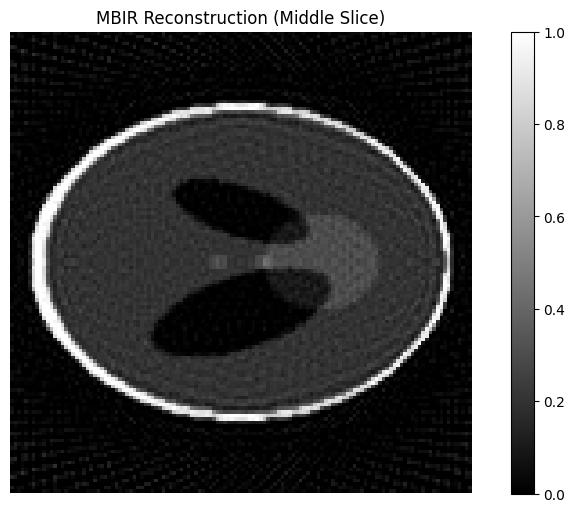

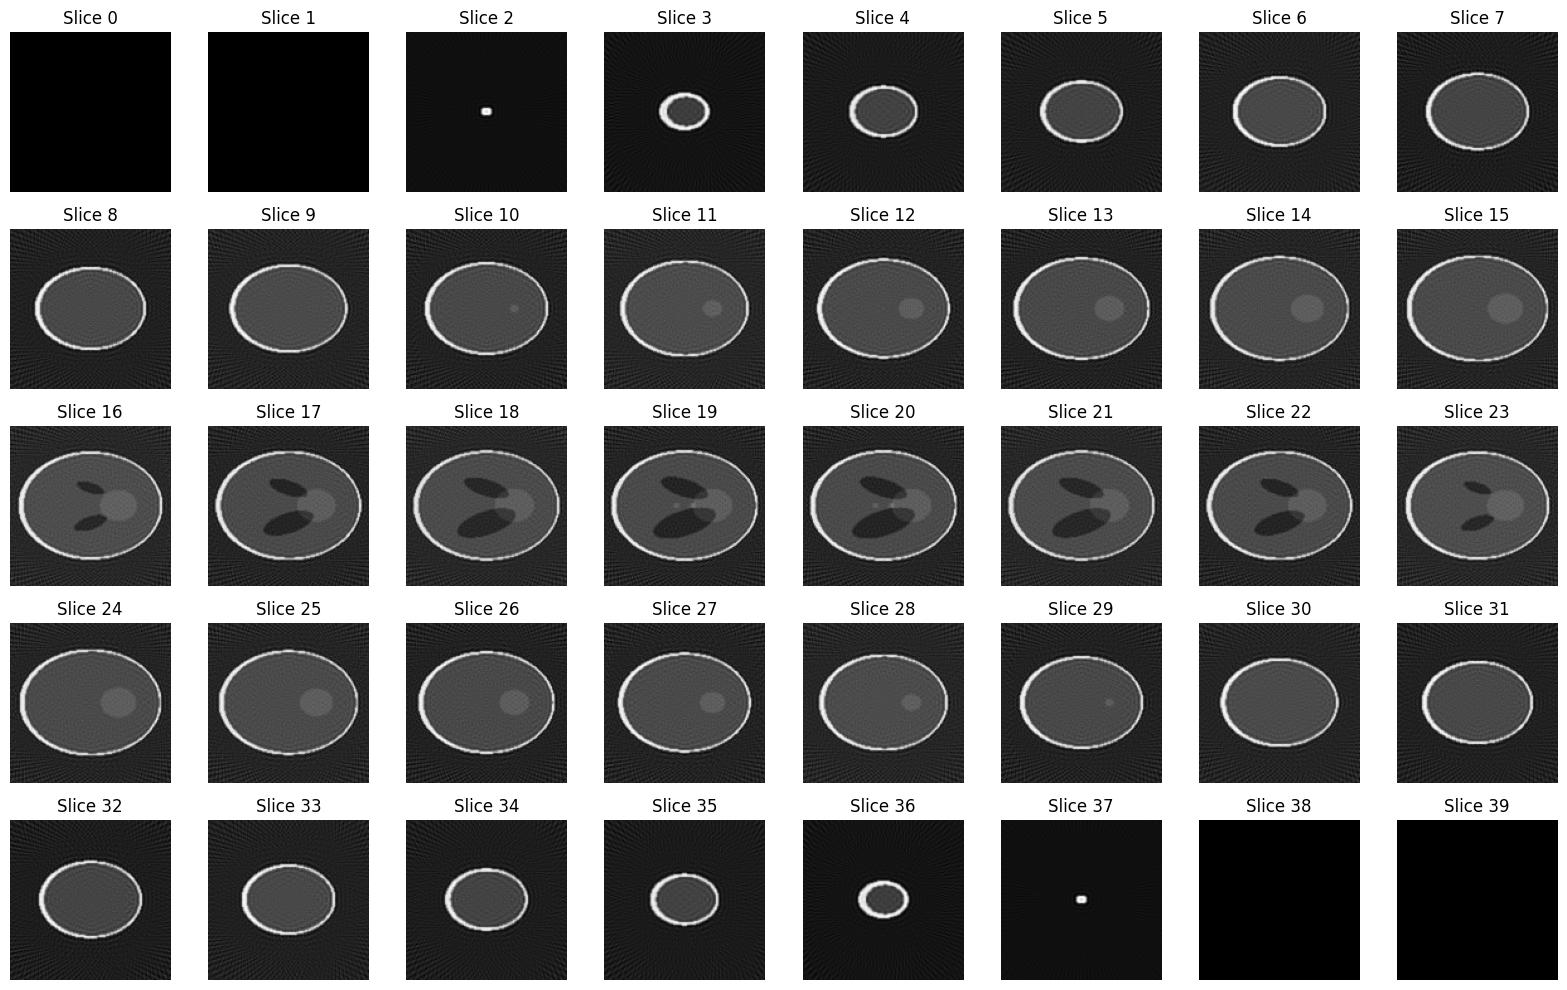

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """Apply 8-connected L2-TV on each 2D slice of 3D volume."""
    height, width, depth = x.shape
    tv_total = 0.0

    offsets = [
        (-1,  0, 1.0),              # Top
        ( 1,  0, 1.0),              # Bottom
        ( 0, -1, 1.0),              # Left
        ( 0,  1, 1.0),              # Right
        (-1, -1, 1 / (2**0.5)),     # Top-left
        (-1,  1, 1 / (2**0.5)),     # Top-right
        ( 1, -1, 1 / (2**0.5)),     # Bottom-left
        ( 1,  1, 1 / (2**0.5)),     # Bottom-right
    ]

    for z in range(depth):
        slice_2d = x[:, :, z]
        slice_tv = 0.0

        for dx, dy, weight in offsets:
            shifted = torch.roll(slice_2d, shifts=(dx, dy), dims=(0, 1))

            # Zero out wrap-around effects
            if dx > 0:
                shifted[:dx, :] = slice_2d[:dx, :]
            elif dx < 0:
                shifted[dx:, :] = slice_2d[dx:, :]
            if dy > 0:
                shifted[:, :dy] = slice_2d[:, :dy]
            elif dy < 0:
                shifted[:, dy:] = slice_2d[:, dy:]

            diff = torch.abs(slice_2d - shifted)
            slice_tv += weight * (diff ** 2).sum()  # Accumulate the weighted TV penalty

        tv_total += slice_tv

    return tv_total


# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 0.01 * tv_term

# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")

# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


## Weight = 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.8/323.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 38.5 MB/s eta 0:00:00
Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-1-e96873dcfd28>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 8.062353610992432
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 10363853.000000
Iteration 100: Loss = 101605.062500
Iteration 150: Loss = 43596.015625
Iteration 200: Loss = 43370.250000
Iteration 250: Loss = 43363.789062
Iteration 300: Loss = 43362.539062
Iteration 350: Loss = 43362.179688
Iteration 400: Loss = 43362.070312
Iteration 450: Loss = 43362.019531
Iteration 500: Loss = 43361.992188
Iteration 550: Loss = 43361.988281
Iteration 600: Loss = 43361.984375
Iteration 650: Loss = 43361.992188
Iteration 700: Loss = 43361.988281
Iteration 750: Loss = 43361.984375
Iteration 800: Loss = 43361.984375
Iteration 850: Loss = 43361.976562
Iteration 900: Loss = 43361.980469
Iteration 950: Loss = 43361.980469
Reconstruction completed.
Reconstructed image saved.


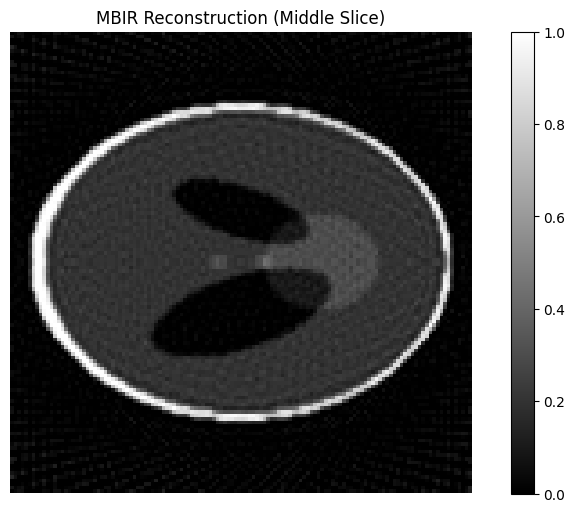

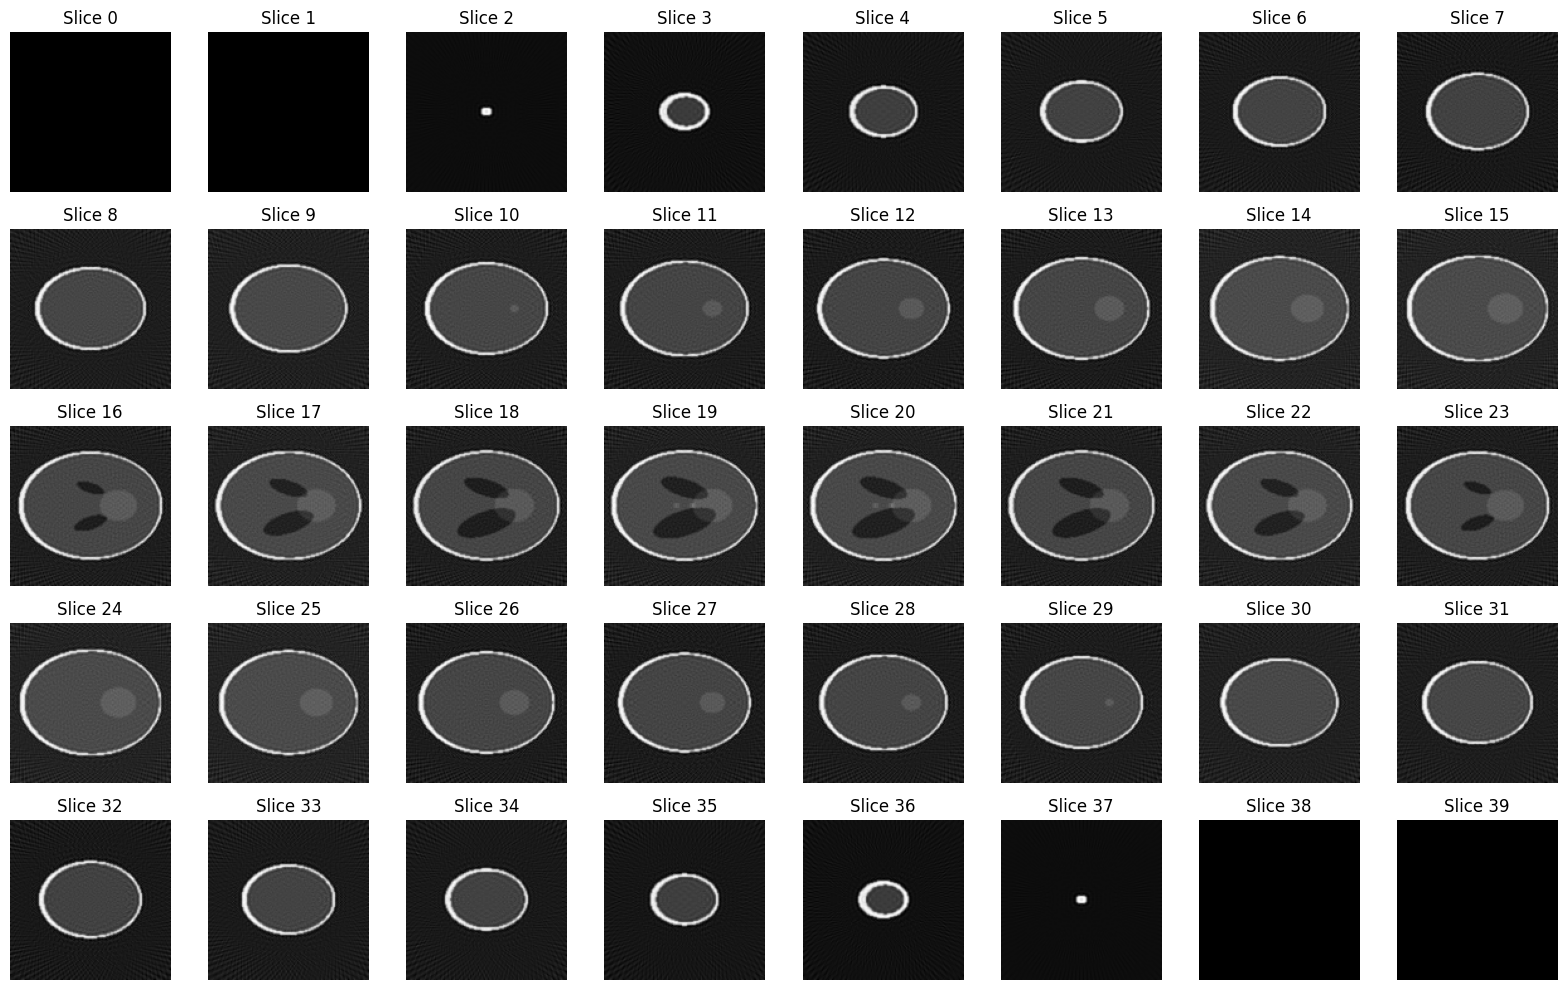

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """Apply 8-connected L2-TV on each 2D slice of 3D volume."""
    height, width, depth = x.shape
    tv_total = 0.0

    offsets = [
        (-1,  0, 1.0),              # Top
        ( 1,  0, 1.0),              # Bottom
        ( 0, -1, 1.0),              # Left
        ( 0,  1, 1.0),              # Right
        (-1, -1, 1 / (2**0.5)),     # Top-left
        (-1,  1, 1 / (2**0.5)),     # Top-right
        ( 1, -1, 1 / (2**0.5)),     # Bottom-left
        ( 1,  1, 1 / (2**0.5)),     # Bottom-right
    ]

    for z in range(depth):
        slice_2d = x[:, :, z]
        slice_tv = 0.0

        for dx, dy, weight in offsets:
            shifted = torch.roll(slice_2d, shifts=(dx, dy), dims=(0, 1))

            # Zero out wrap-around effects
            if dx > 0:
                shifted[:dx, :] = slice_2d[:dx, :]
            elif dx < 0:
                shifted[dx:, :] = slice_2d[dx:, :]
            if dy > 0:
                shifted[:, :dy] = slice_2d[:, :dy]
            elif dy < 0:
                shifted[:, dy:] = slice_2d[:, dy:]

            diff = torch.abs(slice_2d - shifted)
            slice_tv += weight * (diff ** 2).sum()  # Accumulate the weighted TV penalty

        tv_total += slice_tv

    return tv_total


# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 1 * tv_term

# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")

# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


## Weight = 5

Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-2-cadf142362a3>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 2.32965350151062
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 10479434.000000
Iteration 100: Loss = 221631.078125
Iteration 150: Loss = 163721.125000
Iteration 200: Loss = 163517.468750
Iteration 250: Loss = 163516.156250
Iteration 300: Loss = 163516.125000
Iteration 350: Loss = 163516.125000
Iteration 400: Loss = 163516.125000
Iteration 450: Loss = 163516.109375
Iteration 500: Loss = 163516.109375
Iteration 550: Loss = 163516.125000
Iteration 600: Loss = 163516.109375
Iteration 650: Loss = 163516.109375
Iteration 700: Loss = 163516.109375
Iteration 750: Loss = 163516.109375
Iteration 800: Loss = 163516.125000
Iteration 850: Loss = 163516.109375
Iteration 900: Loss = 163516.109375
Iteration 950: Loss = 163516.109375
Reconstruction completed.
Reconstructed image saved.


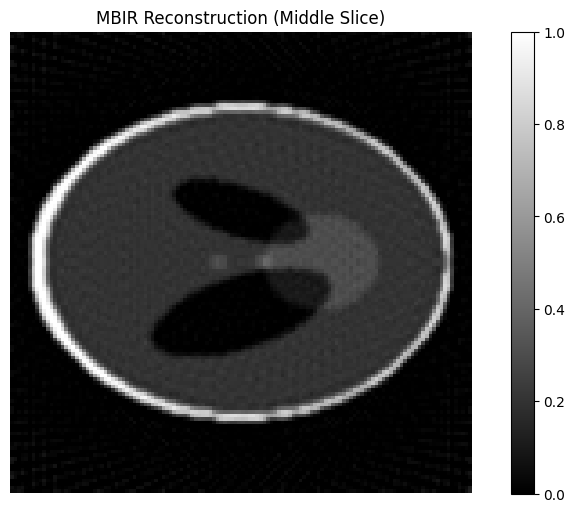

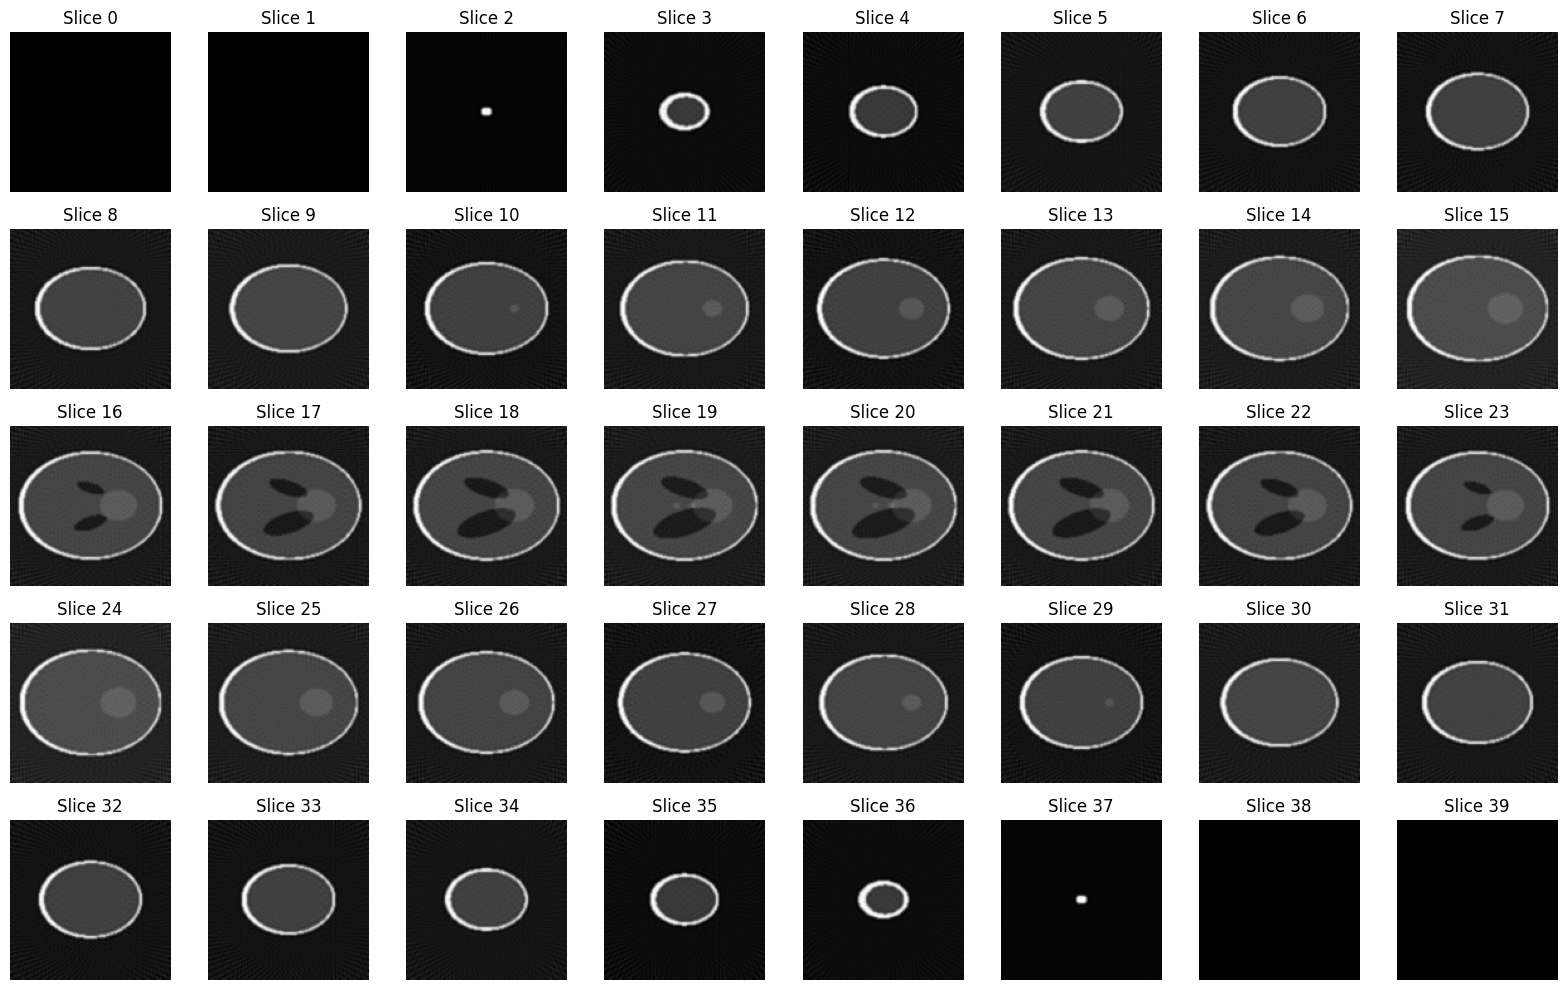

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """Apply 8-connected L2-TV on each 2D slice of 3D volume."""
    height, width, depth = x.shape
    tv_total = 0.0

    offsets = [
        (-1,  0, 1.0),              # Top
        ( 1,  0, 1.0),              # Bottom
        ( 0, -1, 1.0),              # Left
        ( 0,  1, 1.0),              # Right
        (-1, -1, 1 / (2**0.5)),     # Top-left
        (-1,  1, 1 / (2**0.5)),     # Top-right
        ( 1, -1, 1 / (2**0.5)),     # Bottom-left
        ( 1,  1, 1 / (2**0.5)),     # Bottom-right
    ]

    for z in range(depth):
        slice_2d = x[:, :, z]
        slice_tv = 0.0

        for dx, dy, weight in offsets:
            shifted = torch.roll(slice_2d, shifts=(dx, dy), dims=(0, 1))

            # Zero out wrap-around effects
            if dx > 0:
                shifted[:dx, :] = slice_2d[:dx, :]
            elif dx < 0:
                shifted[dx:, :] = slice_2d[dx:, :]
            if dy > 0:
                shifted[:, :dy] = slice_2d[:, :dy]
            elif dy < 0:
                shifted[:, dy:] = slice_2d[:, dy:]

            diff = torch.abs(slice_2d - shifted)
            slice_tv += weight * (diff ** 2).sum()  # Accumulate the weighted TV penalty

        tv_total += slice_tv

    return tv_total



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term

# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")

# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-2-5ecd10a73840>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 3.2618396282196045
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 337526.250000
Iteration 100: Loss = 174775.140625
Iteration 150: Loss = 174329.671875
Iteration 200: Loss = 174327.109375
Iteration 250: Loss = 174327.062500
Iteration 300: Loss = 174327.062500
Iteration 350: Loss = 174327.062500
Iteration 400: Loss = 174327.062500
Iteration 450: Loss = 174327.062500
Iteration 500: Loss = 174327.062500
Iteration 550: Loss = 174327.062500
Iteration 600: Loss = 174327.062500
Iteration 650: Loss = 174327.062500
Iteration 700: Loss = 174327.062500
Iteration 750: Loss = 174327.062500
Iteration 800: Loss = 174327.062500
Iteration 850: Loss = 174327.062500
Iteration 900: Loss = 174327.062500
Iteration 950: Loss = 174327.062500
Reconstruction completed.
Reconstructed image saved.


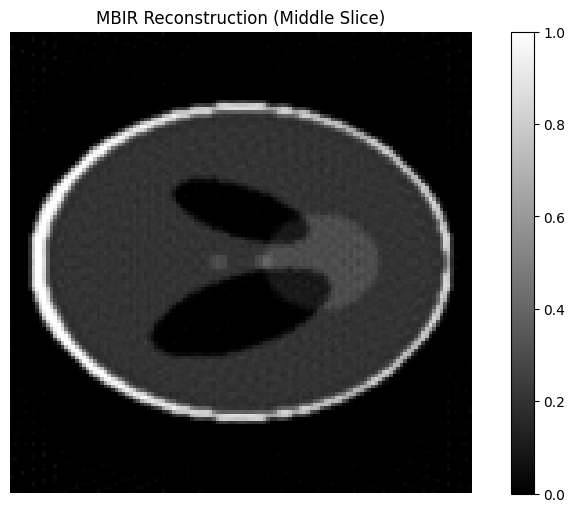

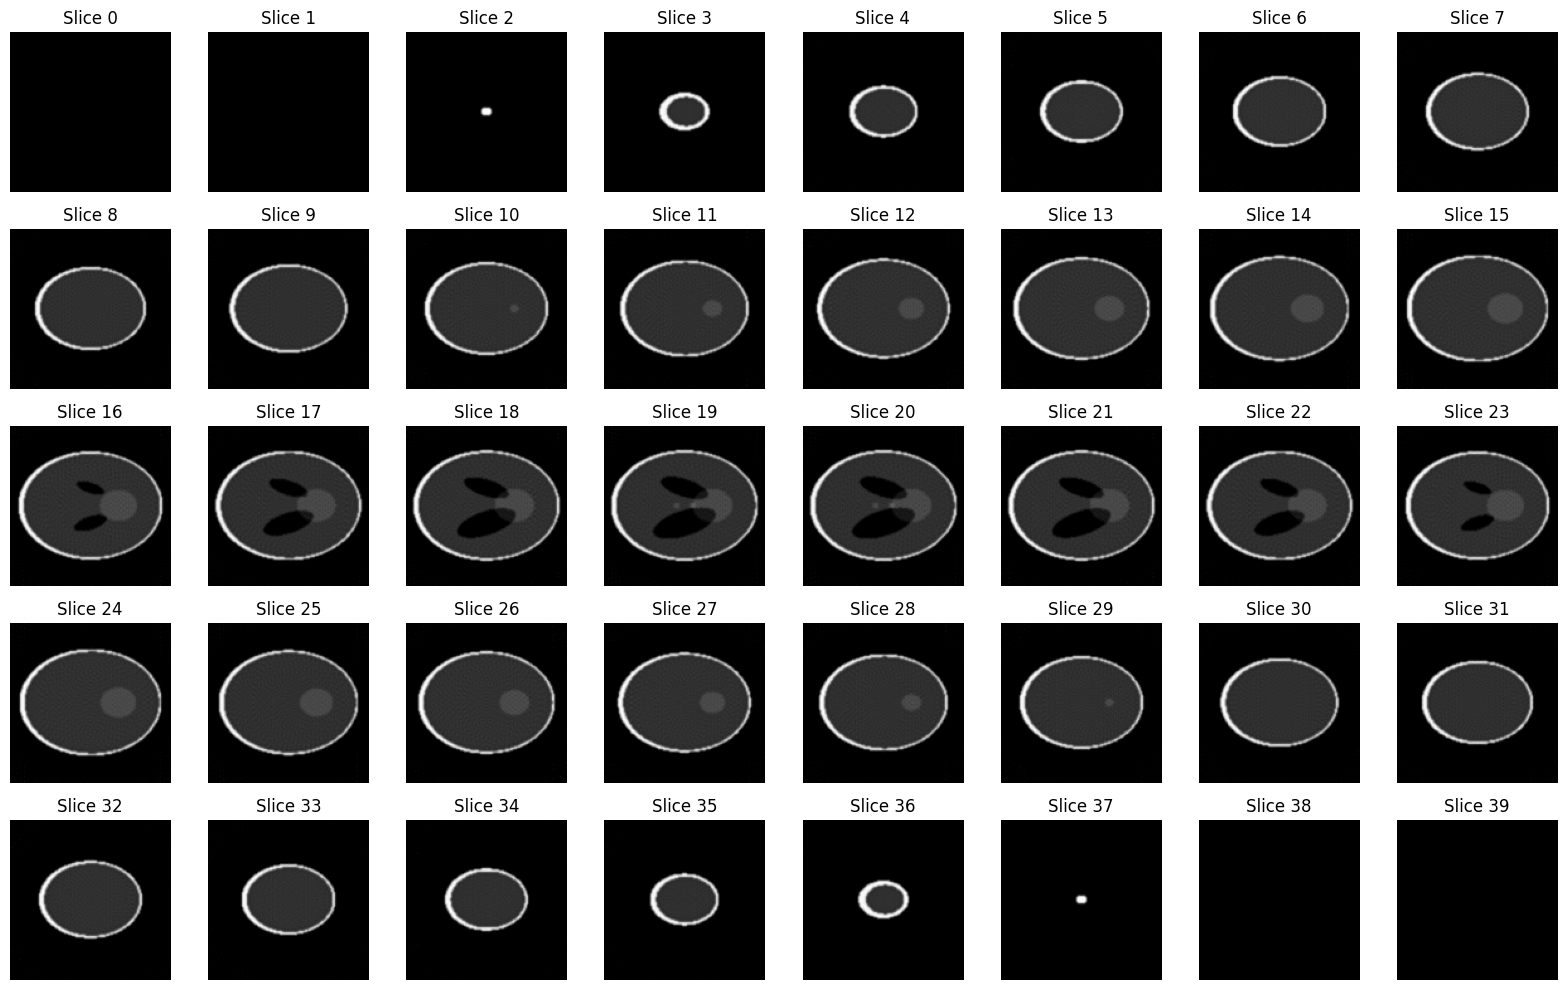

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """Apply 8-connected L2-TV on each 2D slice of 3D volume."""
    height, width, depth = x.shape
    tv_total = 0.0

    offsets = [
        (-1,  0, 1.0),              # Top
        ( 1,  0, 1.0),              # Bottom
        ( 0, -1, 1.0),              # Left
        ( 0,  1, 1.0),              # Right
        (-1, -1, 1 / (2**0.5)),     # Top-left
        (-1,  1, 1 / (2**0.5)),     # Top-right
        ( 1, -1, 1 / (2**0.5)),     # Bottom-left
        ( 1,  1, 1 / (2**0.5)),     # Bottom-right
    ]

    for z in range(depth):
        slice_2d = x[:, :, z]
        slice_tv = 0.0

        for dx, dy, weight in offsets:
            shifted = torch.roll(slice_2d, shifts=(dx, dy), dims=(0, 1))

            # Zero out wrap-around effects
            if dx > 0:
                shifted[:dx, :] = slice_2d[:dx, :]
            elif dx < 0:
                shifted[dx:, :] = slice_2d[dx:, :]
            if dy > 0:
                shifted[:, :dy] = slice_2d[:, :dy]
            elif dy < 0:
                shifted[:, dy:] = slice_2d[:, dy:]

            diff = torch.abs(slice_2d - shifted)
            slice_tv += weight * (diff ** 2).sum()  # Accumulate the weighted TV penalty

        tv_total += slice_tv

    return tv_total



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.8/323.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 32.0 MB/s eta 0:00:00
Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-1-a2f29632eb85>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 6.289135932922363
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 265271.937500
Iteration 100: Loss = 101399.406250
Iteration 150: Loss = 101426.273438
Iteration 200: Loss = 101820.898438
Iteration 250: Loss = 102175.835938
Iteration 300: Loss = 102495.710938
Iteration 350: Loss = 102814.328125
Iteration 400: Loss = 103112.531250
Iteration 450: Loss = 103416.062500
Iteration 500: Loss = 103682.335938
Iteration 550: Loss = 103965.796875
Iteration 600: Loss = 104243.945312
Iteration 650: Loss = 104519.117188
Iteration 700: Loss = 104799.867188
Iteration 750: Loss = 105074.046875
Iteration 800: Loss = 105334.757812
Iteration 850: Loss = 105615.296875
Iteration 900: Loss = 105927.218750
Iteration 950: Loss = 106154.679688
Reconstruction completed.
Reconstructed image saved.


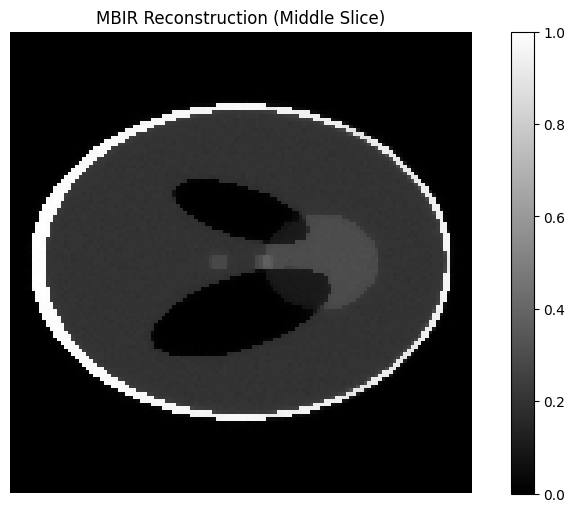

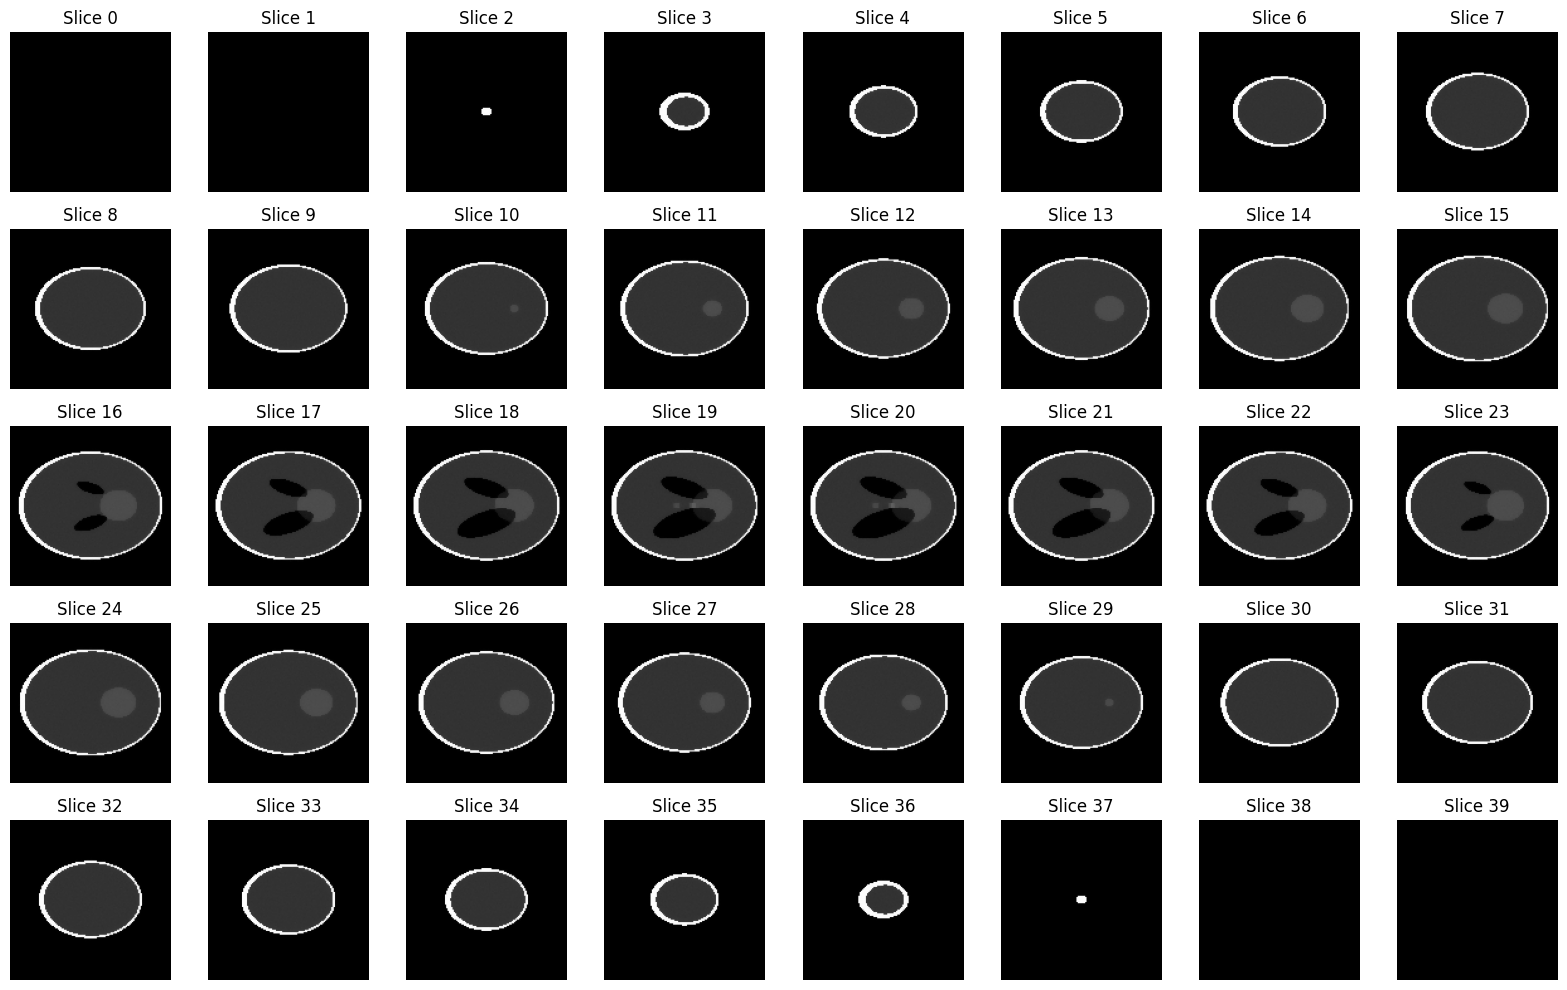

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L1-TV ----------
def custom_l2_norm_3d(x):

    tv_sum = 0.0
    for z in range(x.shape[2]):
        slice_2d = x[:, :, z]
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        tv_sum += torch.sum(torch.abs(vert_diffs)) + torch.sum(torch.abs(horiz_diffs))
    return tv_sum


# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-3-32b07ee43023>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 2.3337416648864746
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 285198.906250
Iteration 100: Loss = 124076.562500
Iteration 150: Loss = 123653.257812
Iteration 200: Loss = 123651.140625
Iteration 250: Loss = 123651.093750
Iteration 300: Loss = 123651.093750
Iteration 350: Loss = 123651.093750
Iteration 400: Loss = 123651.101562
Iteration 450: Loss = 123651.101562
Iteration 500: Loss = 123651.093750
Iteration 550: Loss = 123651.093750
Iteration 600: Loss = 123651.093750
Iteration 650: Loss = 123651.093750
Iteration 700: Loss = 123651.101562
Iteration 750: Loss = 123651.093750
Iteration 800: Loss = 123651.093750
Iteration 850: Loss = 123651.093750
Iteration 900: Loss = 123651.101562
Iteration 950: Loss = 123651.101562
Reconstruction completed.
Reconstructed image saved.


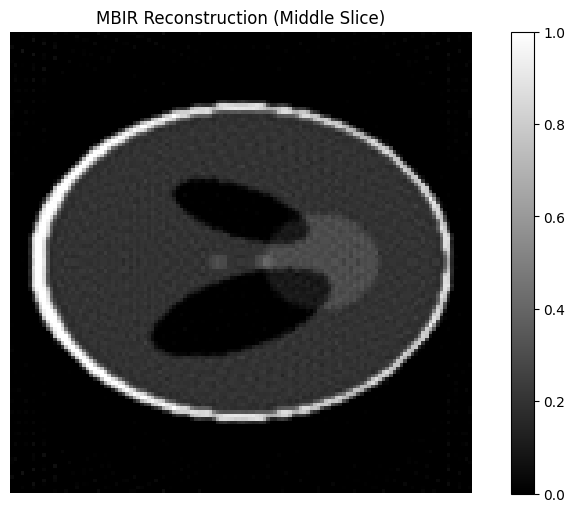

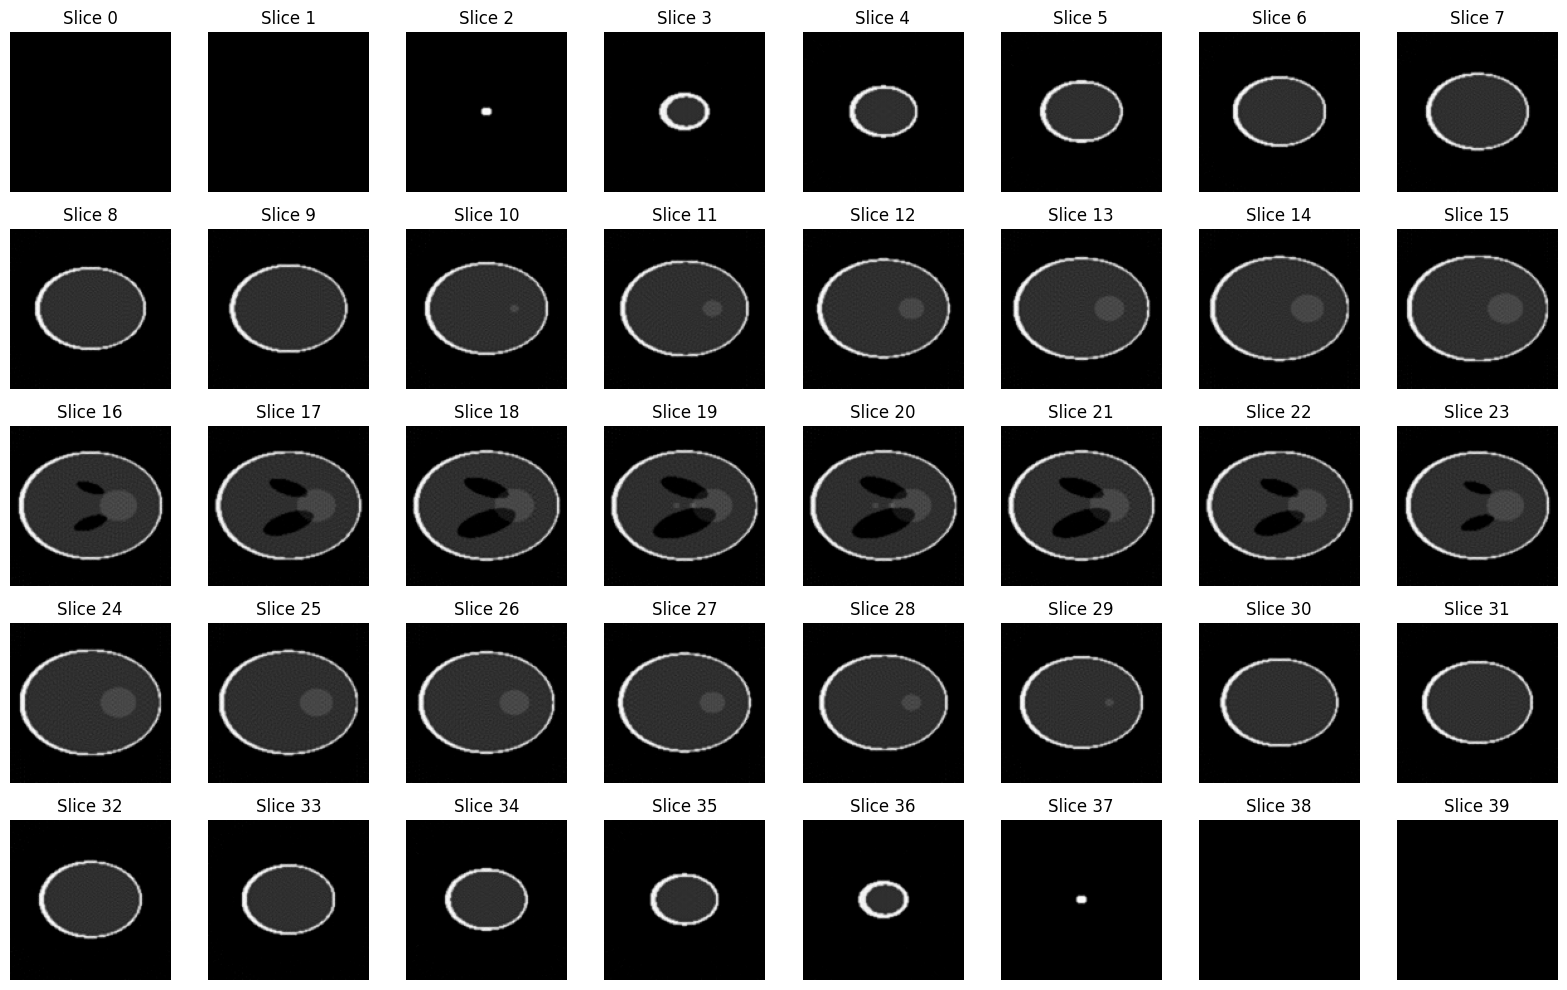

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum squared differences
        tv_sum += torch.sum(horiz_diffs ** 2)
        tv_sum += torch.sum(vert_diffs ** 2)
        tv_sum += torch.sum(diag_main ** 2)
        tv_sum += torch.sum(diag_anti ** 2)

    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 1000

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-5-015e65020753>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.2331461906433105
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 427393.187500
Iteration 100: Loss = 262275.687500
Iteration 150: Loss = 261793.890625
Iteration 200: Loss = 261790.796875
Iteration 250: Loss = 261790.750000
Iteration 300: Loss = 261790.781250
Iteration 350: Loss = 261790.765625
Iteration 400: Loss = 261790.765625
Iteration 450: Loss = 261790.765625
Reconstruction completed.
Reconstructed image saved.


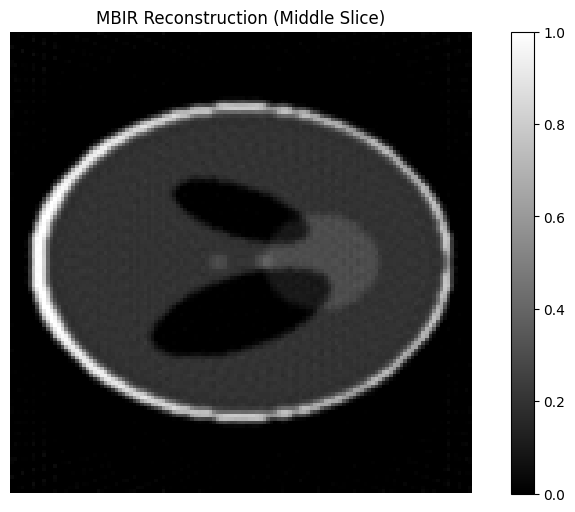

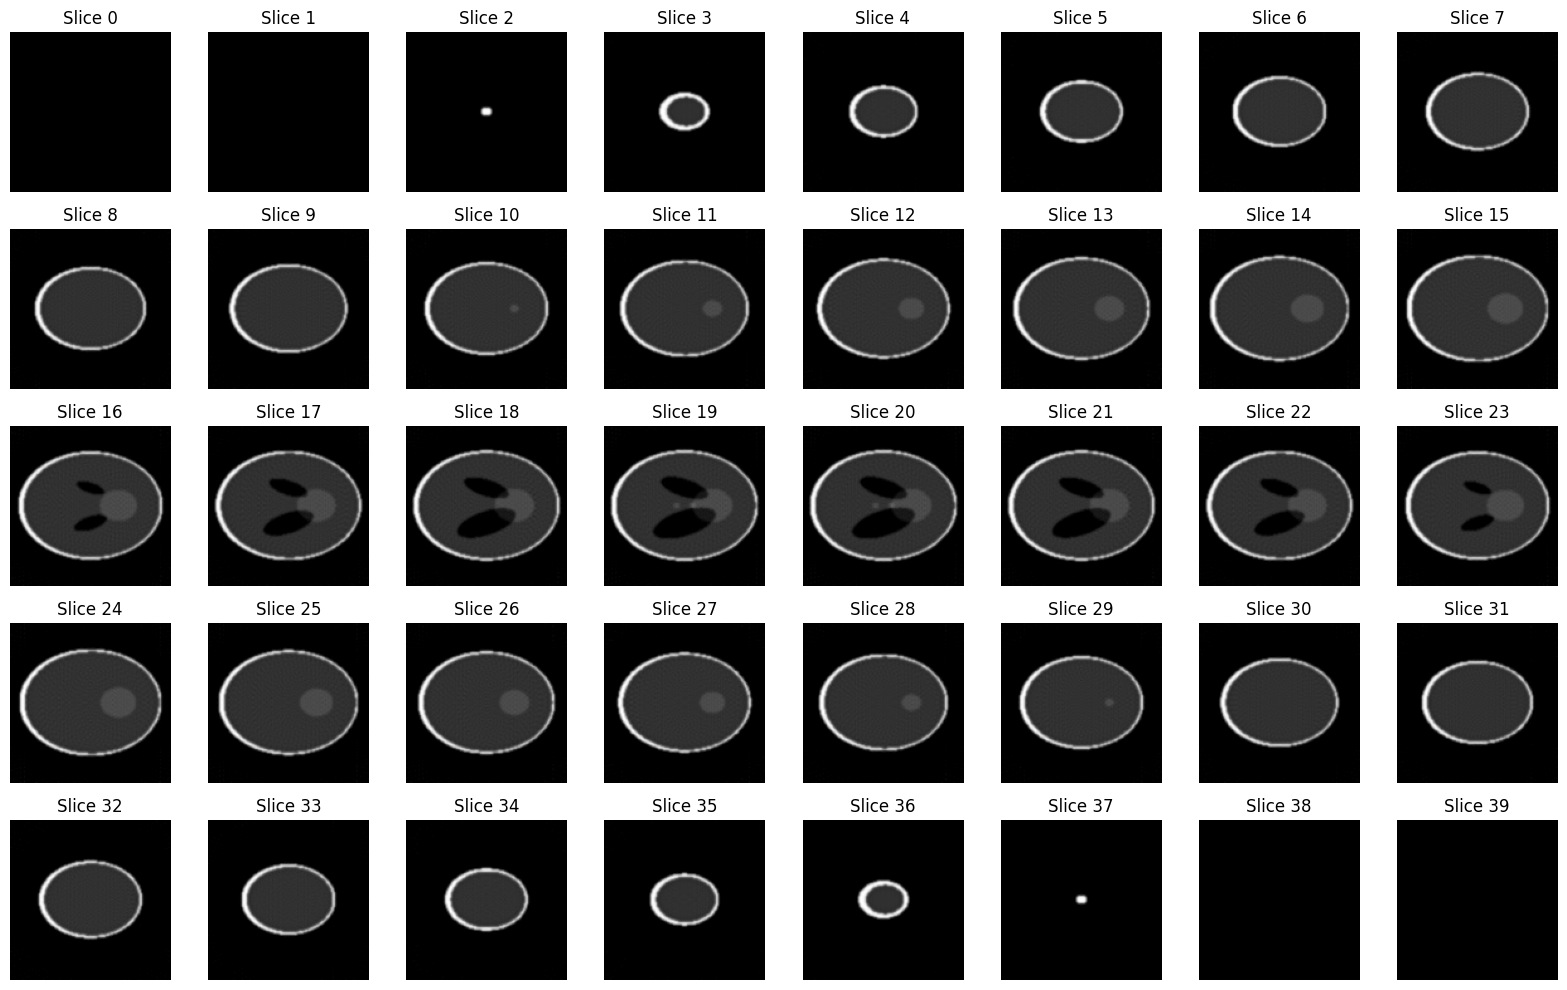

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum squared differences
        tv_sum += torch.sum(horiz_diffs ** 2)
        tv_sum += torch.sum(vert_diffs ** 2)
        tv_sum += torch.sum(diag_main ** 2)
        tv_sum += torch.sum(diag_anti ** 2)

    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 15 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 500

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-6-9757233d7d7b>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.2028424739837646
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 807926.125000
Iteration 100: Loss = 677038.875000
Iteration 150: Loss = 688167.000000
Iteration 200: Loss = 697663.500000
Iteration 250: Loss = 706284.000000
Reconstruction completed.
Reconstructed image saved.


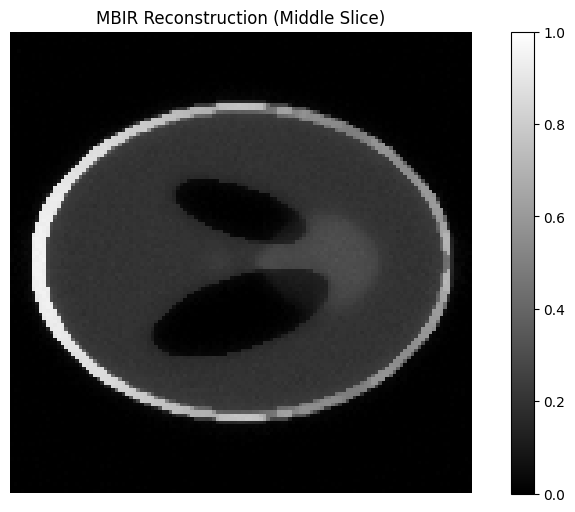

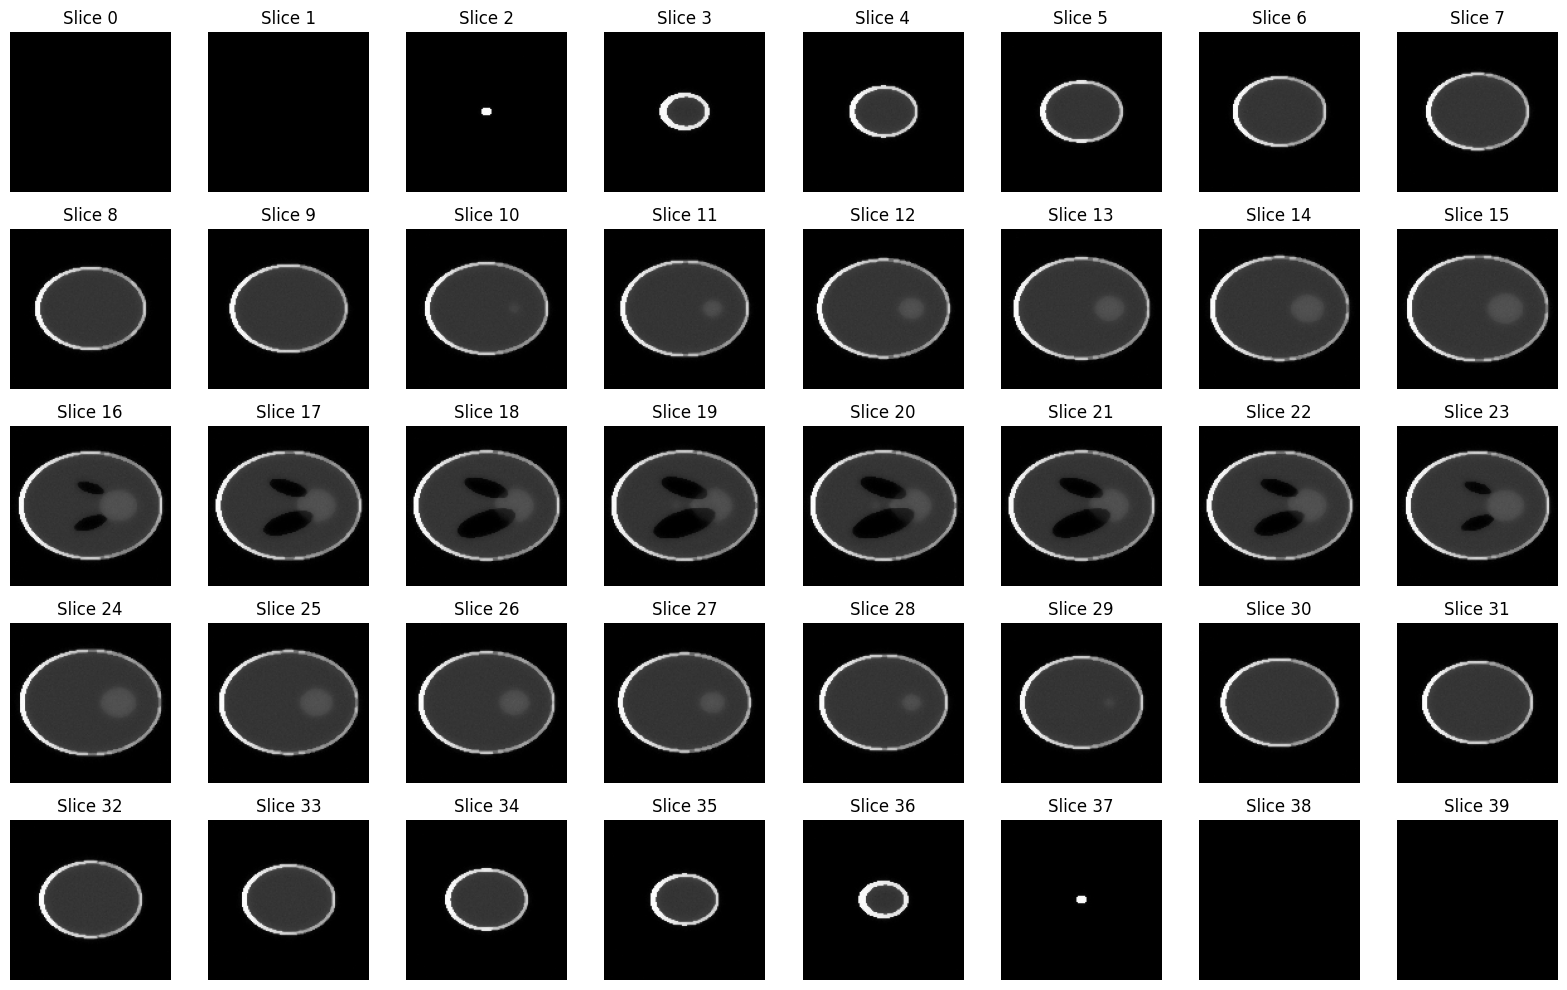

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L1-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum absolute differences instead of squared differences
        tv_sum += torch.sum(torch.abs(horiz_diffs))
        tv_sum += torch.sum(torch.abs(vert_diffs))
        tv_sum += torch.sum(torch.abs(diag_main))
        tv_sum += torch.sum(torch.abs(diag_anti))


    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 15 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 300

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-7-2d9302070b58>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.1715548038482666
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction...
Iteration 0: Loss = 66823936.000000
Iteration 50: Loss = 396416.031250
Iteration 100: Loss = 238504.843750
Iteration 150: Loss = 239506.343750
Iteration 200: Loss = 240568.078125
Iteration 250: Loss = 241501.437500
Reconstruction completed.
Reconstructed image saved.


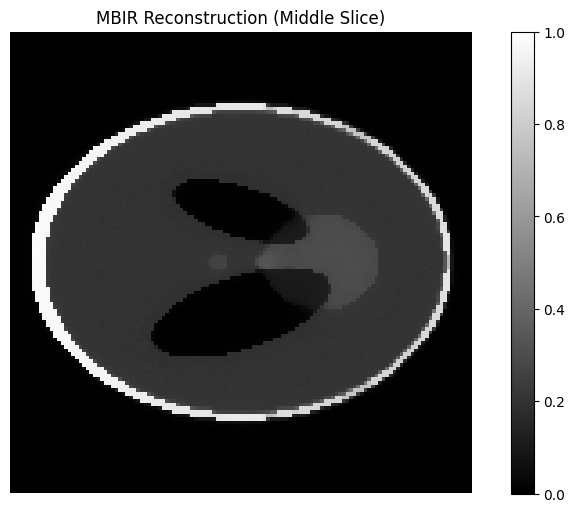

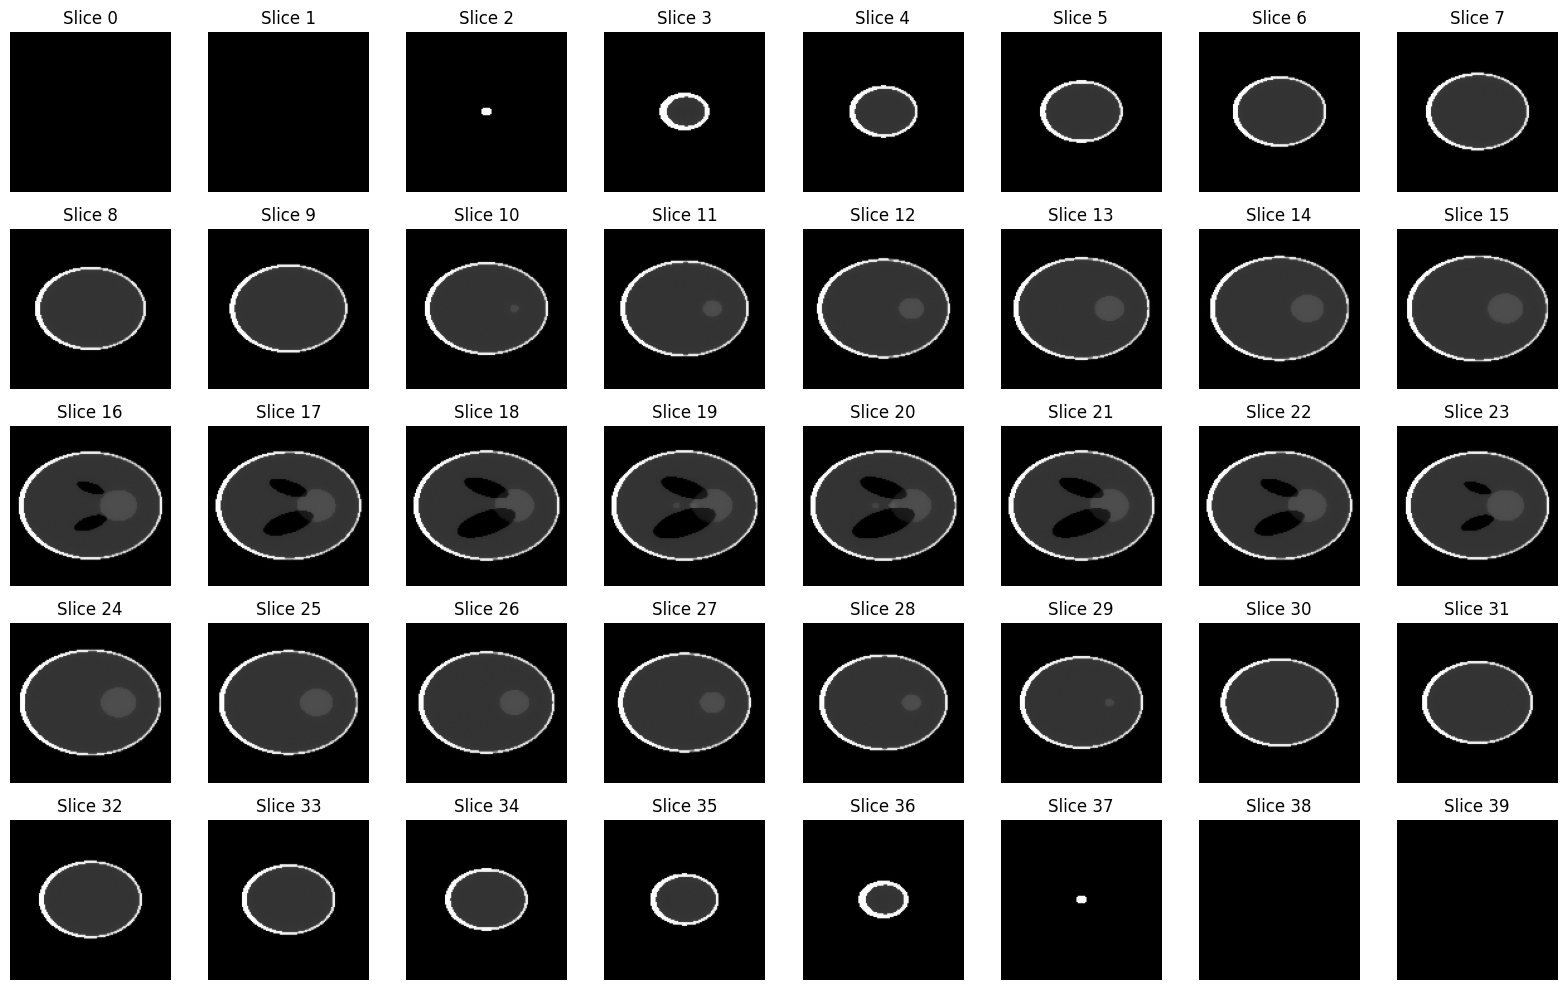

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L1-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum absolute differences instead of squared differences
        tv_sum += torch.sum(torch.abs(horiz_diffs))
        tv_sum += torch.sum(torch.abs(vert_diffs))
        tv_sum += torch.sum(torch.abs(diag_main))
        tv_sum += torch.sum(torch.abs(diag_anti))


    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term


# ---------- Optimization ----------
optimizer = optim.Adam([x_init], lr=1)
num_iterations = 300

print("Starting MBIR Reconstruction...")
for i in range(num_iterations):
    optimizer.zero_grad()
    loss = loss_fn(x_init)
    loss.backward()
    optimizer.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        print(f"Iteration {i}: Loss = {loss.item():.6f}")

print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-8-3193d291e0ab>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.5126988887786865
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction with Scheduler...
Iteration 0: Loss = 66823936.000000, LR = 1.000000
Iteration 50: Loss = 396423.812500, LR = 1.000000
Iteration 100: Loss = 238510.843750, LR = 0.100000
Iteration 150: Loss = 233173.093750, LR = 0.100000
Iteration 200: Loss = 233246.500000, LR = 0.010000
Iteration 250: Loss = 232206.937500, LR = 0.010000
Reconstruction completed.
Reconstructed image saved.


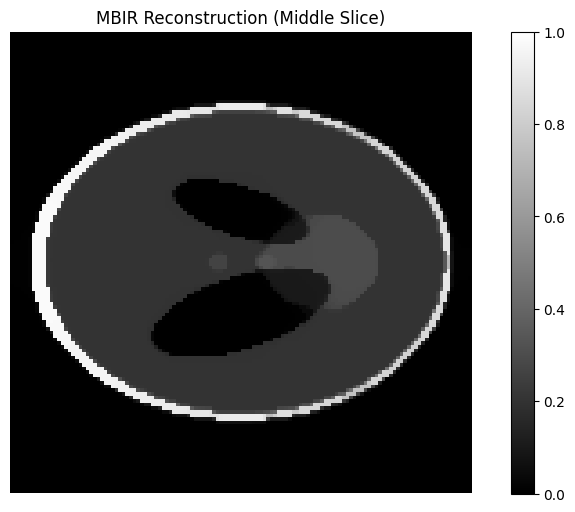

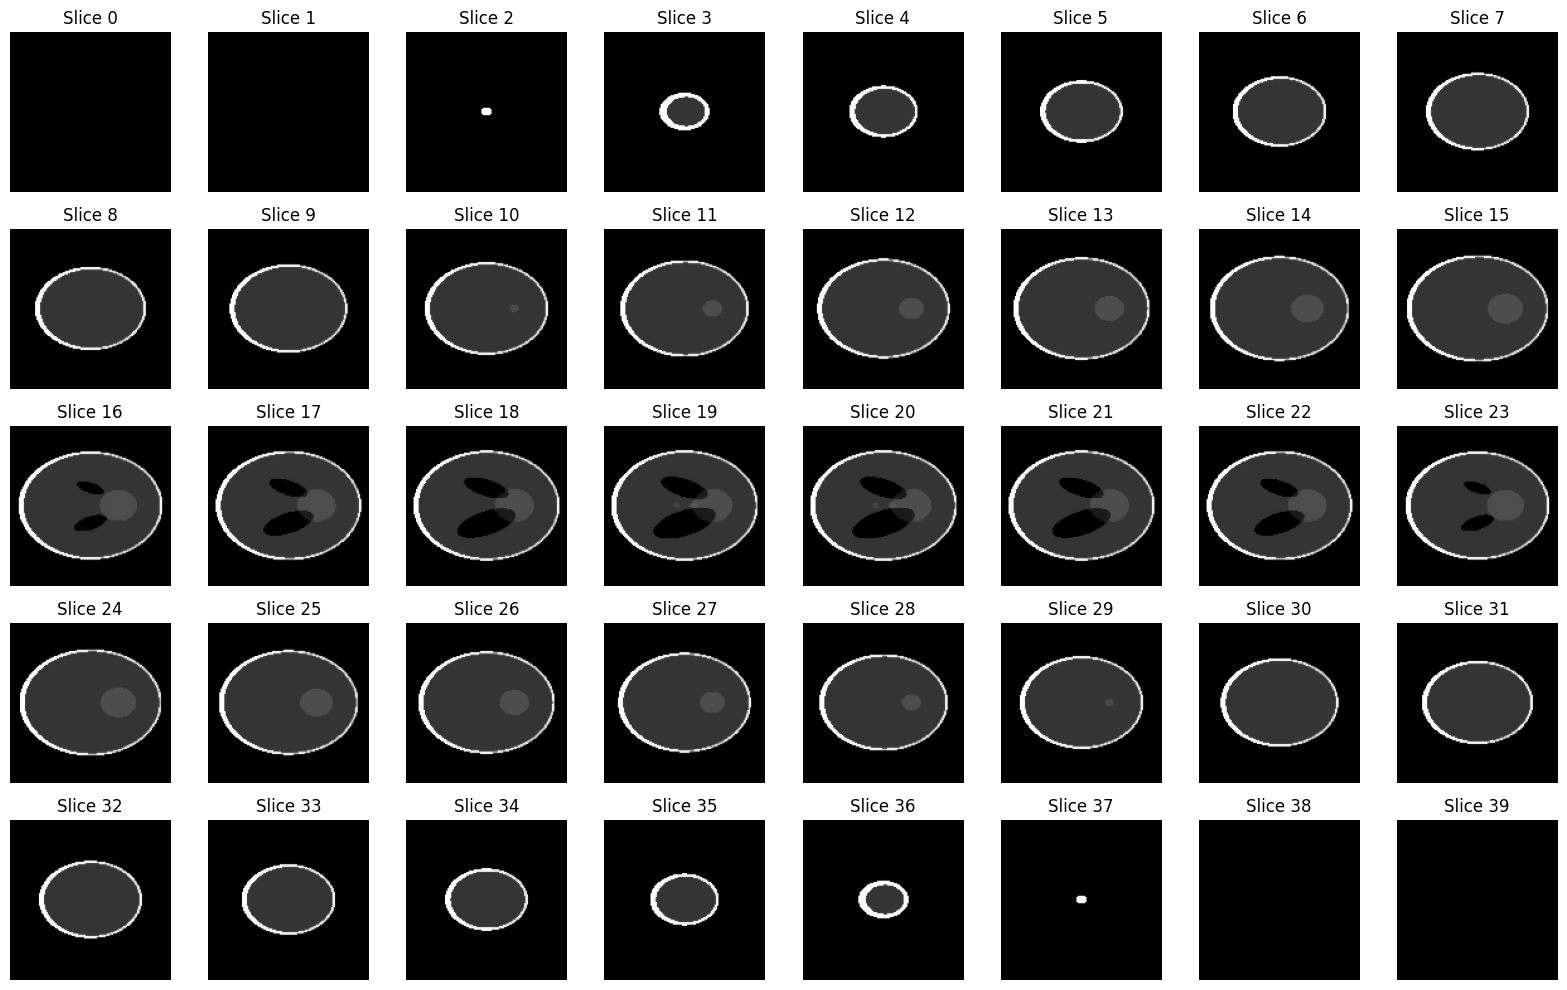

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L1-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum absolute differences instead of squared differences
        tv_sum += torch.sum(torch.abs(horiz_diffs))
        tv_sum += torch.sum(torch.abs(vert_diffs))
        tv_sum += torch.sum(torch.abs(diag_main))
        tv_sum += torch.sum(torch.abs(diag_anti))


    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term

# ---------- Initialize the Optimizer and Scheduler ----------

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize your reconstruction variable
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([x_init], lr=1.0)  # Starting with a higher LR

# Define the scheduler: reduce LR by a factor of 0.1 every 100 iterations
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# ---------- Optimization ----------
num_iterations = 300
print("Starting MBIR Reconstruction with Scheduler...")
for i in range(num_iterations):
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_fn(x_init)
    loss.backward()

    # Update parameters with optimizer
    optimizer.step()

    # Update the learning rate using the scheduler
    scheduler.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Iteration {i}: Loss = {loss.item():.6f}, LR = {current_lr:.6f}")


print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-10-13ea085bffbf>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 2.6878392696380615
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction with Scheduler...
Iteration 0: Loss = 66823936.000000, LR = 1.000000
Iteration 50: Loss = 364912.656250, LR = 1.000000
Iteration 100: Loss = 201398.437500, LR = 0.100000
Iteration 150: Loss = 200946.312500, LR = 0.100000
Iteration 200: Loss = 200942.015625, LR = 0.010000
Iteration 250: Loss = 200942.000000, LR = 0.010000
Reconstruction completed.
Reconstructed image saved.


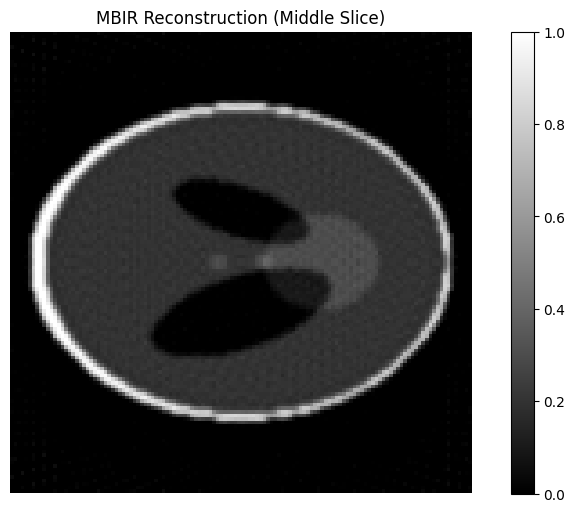

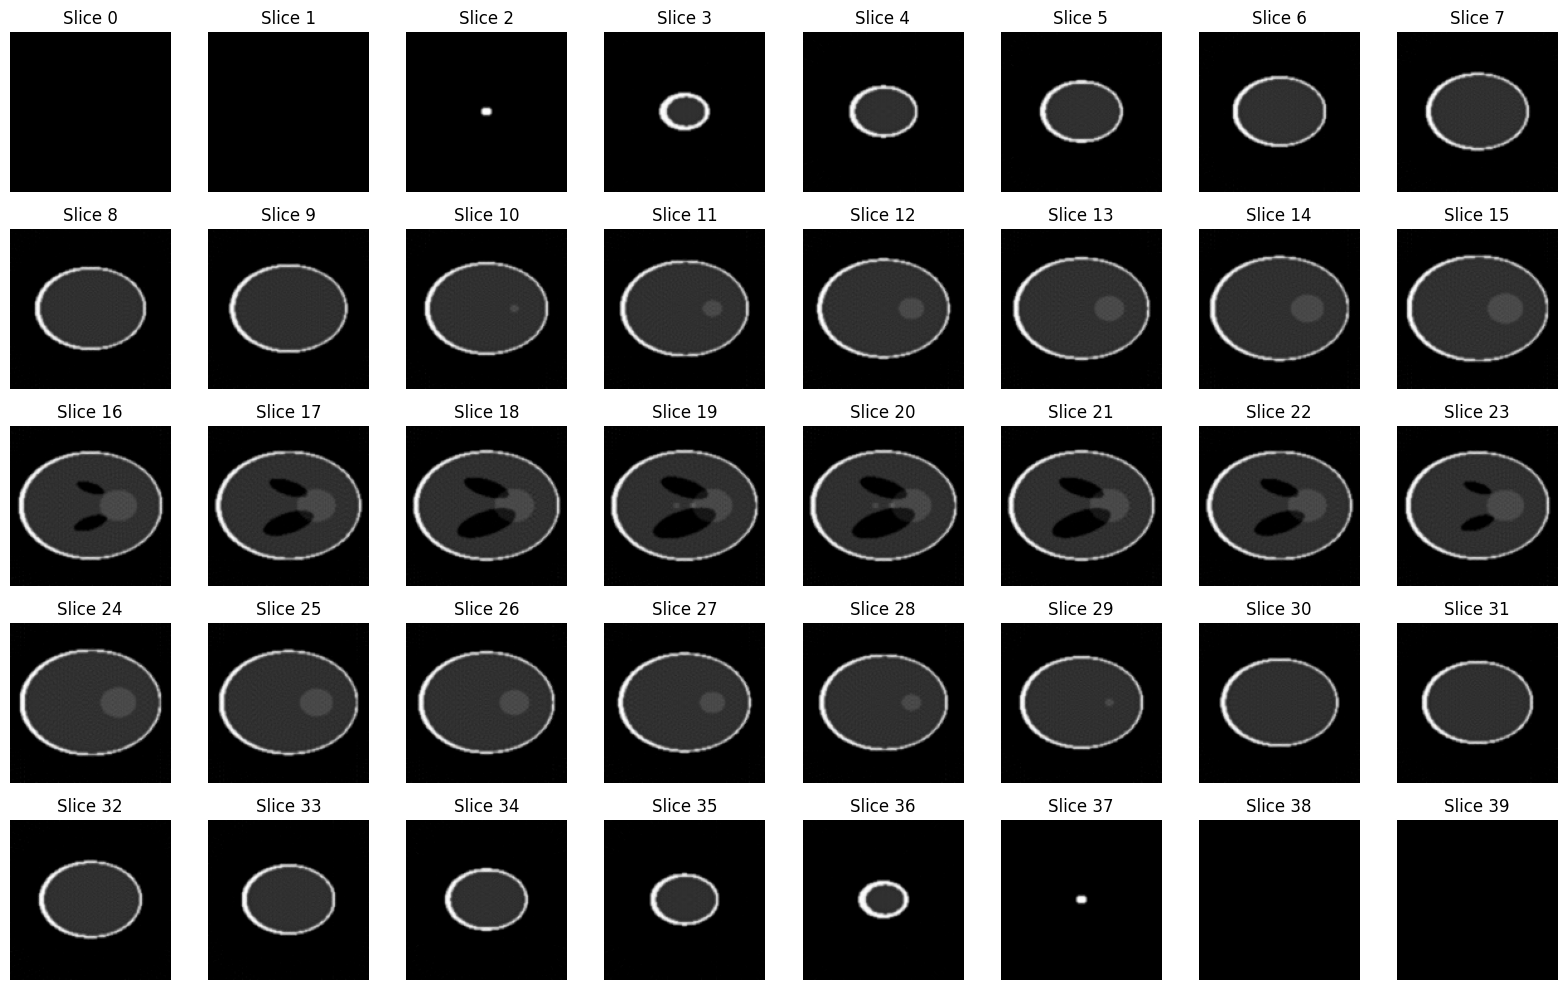

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum absolute differences instead of squared differences
        tv_sum += torch.sum(horiz_diffs ** 2)
        tv_sum += torch.sum(vert_diffs ** 2)
        tv_sum += torch.sum(diag_main ** 2)
        tv_sum += torch.sum(diag_anti ** 2)

    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 10 * tv_term

# ---------- Initialize the Optimizer and Scheduler ----------

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize your reconstruction variable
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([x_init], lr=1.0)  # Starting with a higher LR

# Define the scheduler: reduce LR by a factor of 0.1 every 100 iterations
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# ---------- Optimization ----------
num_iterations = 300
print("Starting MBIR Reconstruction with Scheduler...")
for i in range(num_iterations):
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_fn(x_init)
    loss.backward()

    # Update parameters with optimizer
    optimizer.step()

    # Update the learning rate using the scheduler
    scheduler.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Iteration {i}: Loss = {loss.item():.6f}, LR = {current_lr:.6f}")


print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


Using device: cuda
Available GPU memory = 11.056GB.
Estimated memory required = 0.183GB full, 0.167GB update
Using cuda:0 for main memory, cuda:0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-11-2e4b49eb195c>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 1.797349214553833
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction with Scheduler...
Iteration 0: Loss = 66823936.000000, LR = 1.000000
Iteration 50: Loss = 481868.343750, LR = 1.000000
Iteration 100: Loss = 313553.656250, LR = 0.100000
Iteration 150: Loss = 313042.093750, LR = 0.100000
Iteration 200: Loss = 313039.687500, LR = 0.010000
Iteration 250: Loss = 313039.625000, LR = 0.010000
Reconstruction completed.
Reconstructed image saved.


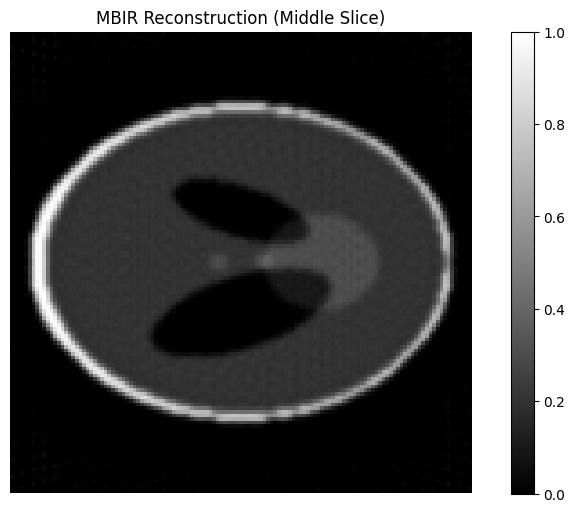

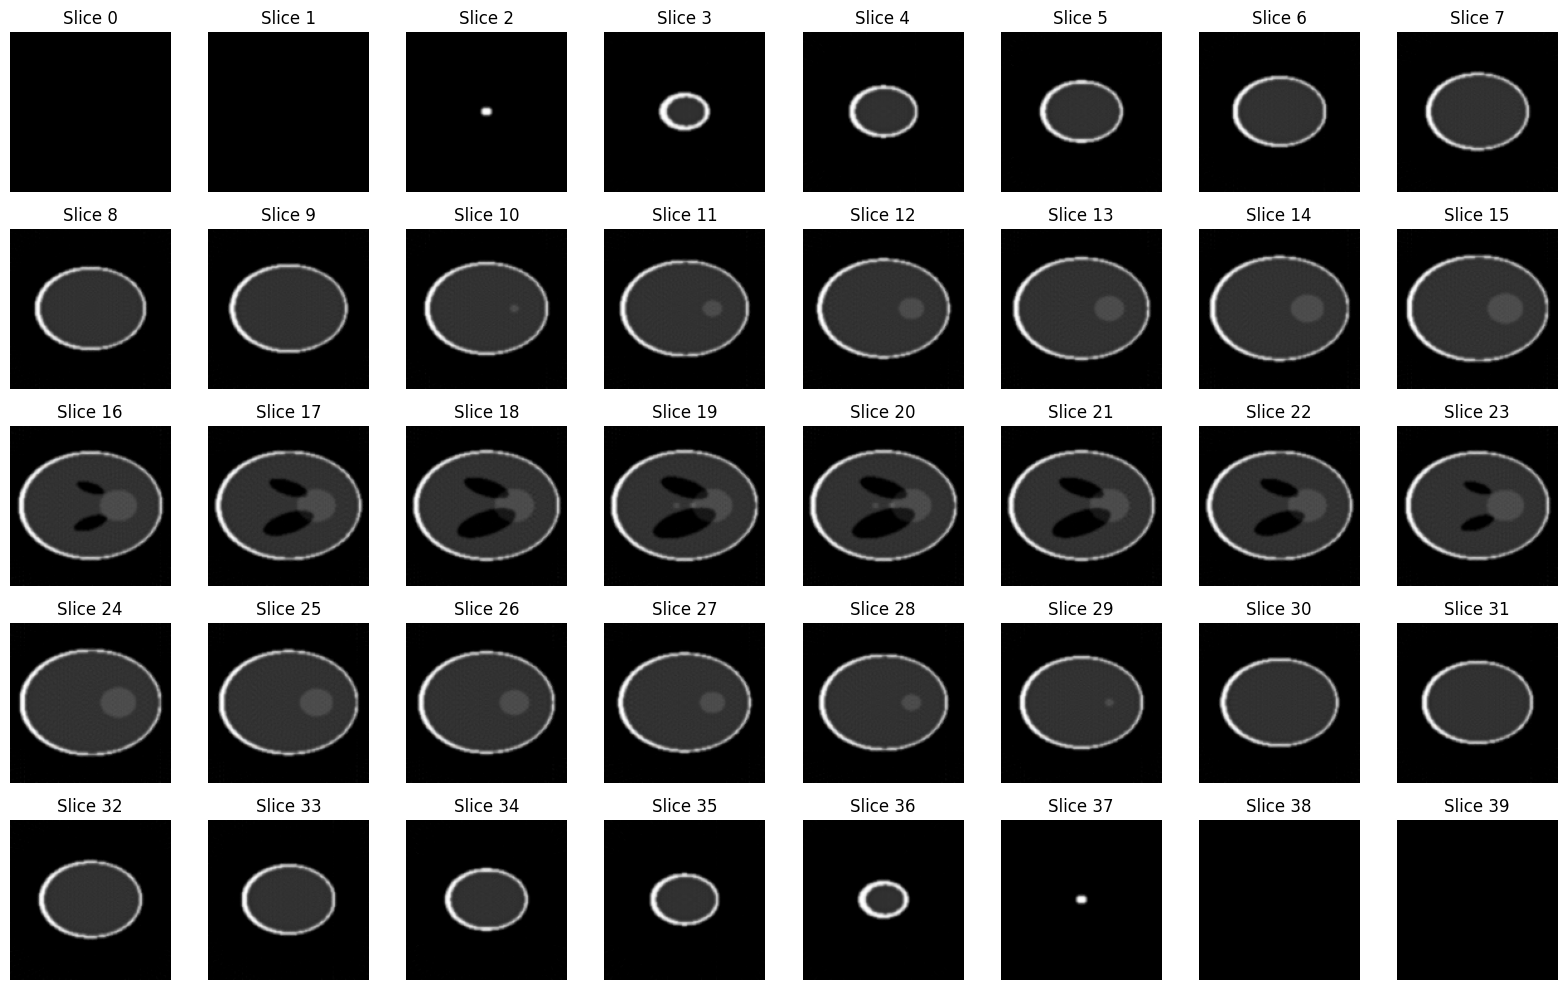

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
def custom_l2_norm_3d(x):
    """
    x: 3D PyTorch tensor of shape (H, W, D).
    Returns: A scalar representing the L2 total variation computed as the sum of squared differences
             in the horizontal, vertical, and both diagonal directions for each 2D slice.
    """
    H, W, D = x.shape
    tv_sum = 0.0

    for z in range(D):
        slice_2d = x[:, :, z]  # (H, W)

        # Horizontal differences (right neighbor)
        horiz_diffs = slice_2d[:, 1:] - slice_2d[:, :-1]
        # Vertical differences (down neighbor)
        vert_diffs = slice_2d[1:, :] - slice_2d[:-1, :]
        # Main diagonal (down-right)
        diag_main = slice_2d[1:, 1:] - slice_2d[:-1, :-1]
        # Anti-diagonal (down-left)
        diag_anti = slice_2d[1:, :-1] - slice_2d[:-1, 1:]

        # Sum absolute differences instead of squared differences
        tv_sum += torch.sum(horiz_diffs ** 2)
        tv_sum += torch.sum(vert_diffs ** 2)
        tv_sum += torch.sum(diag_main ** 2)
        tv_sum += torch.sum(diag_anti ** 2)

    return tv_sum



# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )

    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 20 * tv_term

# ---------- Initialize the Optimizer and Scheduler ----------

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize your reconstruction variable
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([x_init], lr=1.0)  # Starting with a higher LR

# Define the scheduler: reduce LR by a factor of 0.1 every 100 iterations
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# ---------- Optimization ----------
num_iterations = 300
print("Starting MBIR Reconstruction with Scheduler...")
for i in range(num_iterations):
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_fn(x_init)
    loss.backward()

    # Update parameters with optimizer
    optimizer.step()

    # Update the learning rate using the scheduler
    scheduler.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Iteration {i}: Loss = {loss.item():.6f}, LR = {current_lr:.6f}")


print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.8/323.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 15.0 MB/s eta 0:00:00
Using device: cpu
Estimated memory required = 0.183GB full, 0.012GB update
Using TFRT_CPU_0 for main memory, TFRT_CPU_0 as worker.
views_per_batch = 256; pixels_per_batch = 2048
Starting forward projection...


<ipython-input-1-bd56521bfac1>:91: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::scatter_add_. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))


Elapsed time: 11.359829187393188
Sinogram shape: torch.Size([64, 40, 128])
Sinogram loaded successfully.
Starting MBIR Reconstruction with Scheduler...
Iteration 0: Loss = 66824496.000000, LR = 1.000000
Iteration 50: Loss = 332145.062500, LR = 1.000000
Iteration 100: Loss = 172693.281250, LR = 0.100000
Iteration 150: Loss = 170638.937500, LR = 0.100000
Iteration 200: Loss = 170633.453125, LR = 0.010000
Iteration 250: Loss = 170524.953125, LR = 0.010000
Reconstruction completed.
Reconstructed image saved.


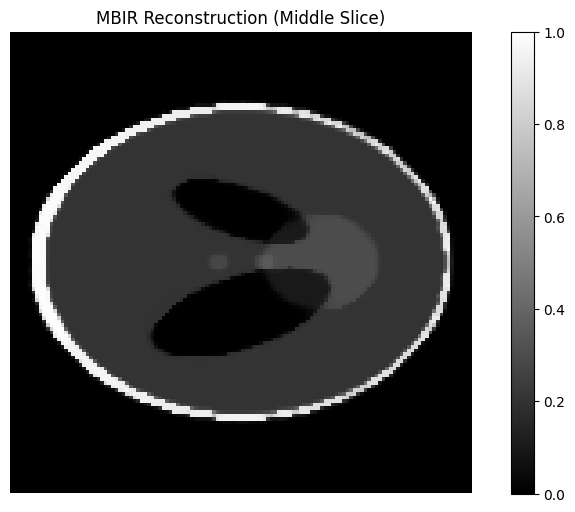

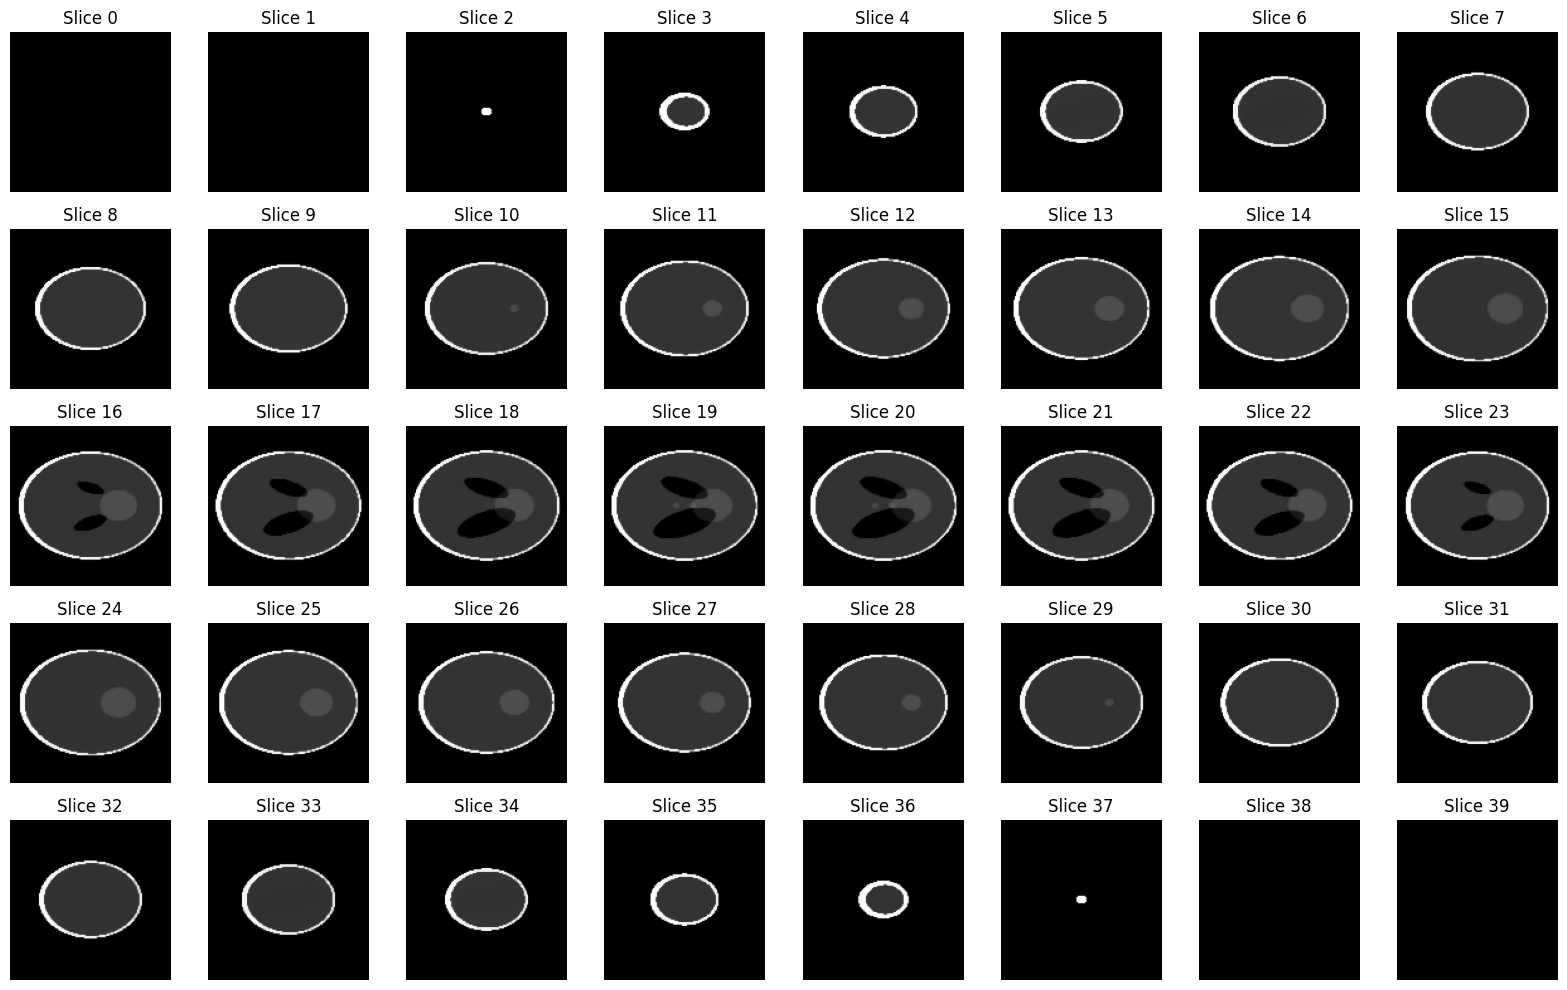

In [ ]:
!pip install mbirjax

import numpy as np
import torch
import jax.numpy as jnp
import mbirjax
import time
import torch.optim as optim
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print(f"Using device: {device}")

# Parameters
num_views = 64
num_det_rows = 40
num_det_channels = 128
geometry_type = "parallel"
angles = jnp.linspace(-np.pi / 2, np.pi / 2, num_views, endpoint=False)

# CT model setup
if geometry_type == "parallel":
    ct_model = mbirjax.ParallelBeamModel((num_views, num_det_rows, num_det_channels), angles)
else:
    raise ValueError("Invalid geometry type. Expected parallel.")

phantom = np.array(ct_model.gen_modified_3d_sl_phantom())
np.save("phantom.npy", phantom)
phantom = torch.tensor(phantom, dtype=torch.float32, device=device)

# ---------- Forward Projection Utilities ----------

def sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles):
    max_views = 4
    max_pixels = 512

    num_views = len(angles)
    view_batch_indices = torch.arange(0, num_views, step=max_views, device=device)
    view_batch_indices = torch.cat([view_batch_indices, torch.tensor([num_views], dtype=torch.int32, device=device)])

    num_pixels = len(indices)
    pixel_batch_indices = torch.arange(0, num_pixels, step=max_pixels, device=device)
    pixel_batch_indices = torch.cat([pixel_batch_indices, torch.tensor([num_pixels], dtype=torch.int32, device=device)])

    sinogram = []

    for j in range(len(view_batch_indices) - 1):
        view_index_start = view_batch_indices[j]
        view_index_end = view_batch_indices[j+1]
        cur_view_batch = torch.zeros((view_index_end - view_index_start, sinogram_shape[1], sinogram_shape[2]), device=device)
        cur_view_params_batch = angles[view_index_start:view_index_end]

        for k in range(len(pixel_batch_indices) - 1):
            pixel_index_start = pixel_batch_indices[k]
            pixel_index_end = pixel_batch_indices[k+1]
            cur_voxel_batch = voxel_values[pixel_index_start:pixel_index_end].to(device)
            cur_index_batch = indices[pixel_index_start:pixel_index_end].to(device)

            def forward_project_pixel_batch_local(view, angle):
                return forward_project_pixel_batch_to_one_view(cur_voxel_batch, cur_index_batch, angle, view,
                                                               sinogram_shape, recon_shape)

            view_map = torch.vmap(forward_project_pixel_batch_local)
            cur_view_batch = view_map(cur_view_batch, cur_view_params_batch)

        sinogram.append(cur_view_batch)

    return torch.cat(sinogram)

def forward_project_pixel_batch_to_one_view(voxel_values, pixel_indices, angle, sinogram_view, sinogram_shape, recon_shape):
    num_views, num_det_rows, num_det_channels = sinogram_shape
    delta_voxel = 1

    n_p, n_p_center, W_p_c, cos_alpha_p_xy = compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape)
    L_max = torch.clip(W_p_c, None, 1)

    for n_offset in range(-1, 2):
        n = n_p_center + n_offset
        abs_delta_p_c_n = torch.abs(n_p - n)
        L_p_c_n = torch.minimum(torch.clamp((W_p_c + 1) / 2 - abs_delta_p_c_n, min=0), L_max)

        A_chan_n = delta_voxel * L_p_c_n / cos_alpha_p_xy
        A_chan_n *= (n >= 0) * (n < num_det_channels)
        n = torch.clamp(n, 0, num_det_channels - 1)

        indices = n.expand(num_det_rows, -1).long()
        sinogram_update = torch.zeros_like(sinogram_view)
        sinogram_update.scatter_add_(1, indices, (A_chan_n.reshape((1, -1)) * voxel_values.T))
        sinogram_view = sinogram_view + sinogram_update

    return sinogram_view

def compute_proj_data(pixel_indices, angle, sinogram_shape, recon_shape):
    cosine = torch.cos(angle)
    sine = torch.sin(angle)
    delta_voxel = 1.0
    dvc = delta_voxel * cosine
    dvs = delta_voxel * sine

    num_views, num_det_rows, num_det_channels = sinogram_shape
    row_index, col_index = torch.unravel_index(pixel_indices, recon_shape[:2])

    y_tilde = dvs * (row_index - (recon_shape[0] - 1) / 2.0)
    x_tilde = dvc * (col_index - (recon_shape[1] - 1) / 2.0)
    x_p = x_tilde - y_tilde
    det_center_channel = (num_det_channels - 1) / 2.0
    n_p = x_p + det_center_channel
    n_p_center = torch.round(n_p).type(torch.int32)
    cos_alpha_p_xy = torch.maximum(torch.abs(cosine), torch.abs(sine))
    W_p_c = cos_alpha_p_xy

    return n_p, n_p_center, W_p_c, cos_alpha_p_xy

# ---------- Forward Project Phantom ----------
sinogram_shape = (num_views, num_det_rows, num_det_channels)
recon_shape = (num_det_channels, num_det_channels, num_det_rows)

angles = torch.linspace(0, torch.pi, steps=num_views, device=device)
indices = torch.arange(recon_shape[0] * recon_shape[1], dtype=torch.int32, device=device)
voxel_values = phantom.reshape((-1,) + recon_shape[2:])[indices]

print("Starting forward projection...")
t0 = time.time()
sinogram = sparse_forward_project(voxel_values, indices, sinogram_shape, recon_shape, angles)
print("Elapsed time:", time.time() - t0)
print(f"Sinogram shape: {sinogram.shape}")
np.savez("sinogram_data.npz", sinogram=sinogram.cpu().numpy(), angles=angles.cpu().numpy())

# ---------- Load Sinogram ----------
data = np.load("sinogram_data.npz")
y = torch.tensor(data["sinogram"], dtype=torch.float32, device=device)
angles = torch.tensor(data["angles"], dtype=torch.float32, device=device)
print("Sinogram loaded successfully.")

weight_L2 = 0.01

# ---------- L2-TV ----------
import torch.nn.functional as F
import numpy as np

def custom_l2_norm_3d(x):
    total_tv = 0.0
    H, W, D = x.shape
    eps = 1e-8  # small epsilon to ensure numerical stability
    for z in range(D):
        slice_2d = x[:, :, z].unsqueeze(0).unsqueeze(0)
        vertical_diff = slice_2d[:, :, 1:, :] - slice_2d[:, :, :-1, :]
        horizontal_diff = slice_2d[:, :, :, 1:] - slice_2d[:, :, :, :-1]
        diag1_diff = slice_2d[:, :, 1:, 1:] - slice_2d[:, :, :-1, :-1]
        diag2_diff = slice_2d[:, :, 1:, :-1] - slice_2d[:, :, :-1, 1:]

        vertical_diff = F.pad(vertical_diff, (0, 0, 0, 1))
        horizontal_diff = F.pad(horizontal_diff, (0, 1, 0, 0))
        diag1_diff = F.pad(diag1_diff, (0, 1, 0, 1))
        diag2_diff = F.pad(diag2_diff, (1, 0, 0, 1))

        tv_slice = torch.sum(torch.sqrt(torch.clamp(vertical_diff ** 2 + horizontal_diff ** 2, min=eps)) +
                             (1 / np.sqrt(2)) * torch.sqrt(torch.clamp(diag1_diff ** 2 + diag2_diff ** 2, min=eps)))
        total_tv += tv_slice
    return total_tv





# ---------- Loss Function ----------
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

def loss_fn(x):
    Ax = sparse_forward_project(
        x.reshape(-1, recon_shape[2]),
        torch.arange(x.numel() // recon_shape[2], dtype=torch.int32, device=device),
        sinogram_shape, recon_shape, angles
    )
    fidelity_term = torch.sum((y - Ax) ** 2)
    tv_term = custom_l2_norm_3d(x)
    return fidelity_term + 5 * tv_term


# ---------- Initialize the Optimizer and Scheduler ----------

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize your reconstruction variable
x_init = torch.zeros(recon_shape, dtype=torch.float32, requires_grad=True, device=device)

# Define the optimizer
optimizer = optim.Adam([x_init], lr=1.0)  # Starting with a higher LR

# Define the scheduler: reduce LR by a factor of 0.1 every 100 iterations
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

# ---------- Optimization ----------
num_iterations = 300
print("Starting MBIR Reconstruction with Scheduler...")
for i in range(num_iterations):
    optimizer.zero_grad()

    # Compute the loss
    loss = loss_fn(x_init)
    loss.backward()

    # Update parameters with optimizer
    optimizer.step()

    # Update the learning rate using the scheduler
    scheduler.step()

    # Clip negative voxel values to 0 after each iteration
    with torch.no_grad():
        x_init.clamp_(min=0)

    if i % 50 == 0:
        current_lr = scheduler.get_last_lr()[0]
        print(f"Iteration {i}: Loss = {loss.item():.6f}, LR = {current_lr:.6f}")


print("Reconstruction completed.")
np.save("mbir_reconstruction.npy", x_init.detach().cpu().numpy())
print("Reconstructed image saved.")


# ---------- Visualization ----------
mbir_reconstruction = np.load("mbir_reconstruction.npy")
mid_slice = mbir_reconstruction.shape[2] // 2

plt.figure(figsize=(10, 6))
plt.imshow(mbir_reconstruction[:, :, mid_slice], cmap="gray", vmin=0, vmax=1)
plt.title("MBIR Reconstruction (Middle Slice)")
plt.axis("off")
plt.colorbar()
plt.show()

# Grid of all slices
num_slices = mbir_reconstruction.shape[2]
cols = 8
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
for i in range(num_slices):
    row, col = divmod(i, cols)
    axes[row, col].imshow(mbir_reconstruction[:, :, i], cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Slice {i}")

for i in range(num_slices, rows * cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()
